In [ ]:
#import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import time
import itertools

In [3]:
#baca file dataset
filePath1 = 'dataset/klasering_dataset.txt'
dataTesting1 = np.loadtxt(filePath1, delimiter=" ")

In [ ]:
#parameter pada kernel k-means
k = 2 #banyaknya klaster
std = 5 #standard deviation di kernel rbf
iterationCounter = 0
input = dataTesting1 #data yang ingin kita klaster
initMethod = "random" #options = random, byCenterDistance, byOriginDistance

In [5]:
#fungsi untuk menginisiasi anggota klaster
def initCluster(dataInput, nCluster, method):
    listClusterMember = [[] for i in range(nCluster)]
    if (method == "random"):
        shuffledDataIn = dataInput
        np.random.shuffle(shuffledDataIn)
        for i in range(0, dataInput.shape[0]):
            listClusterMember[i%nCluster].append(dataInput[i,:])
    if (method == "byCenterDistance"):
        center = np.matrix(np.mean(dataInput, axis=0))
        repeatedCent = np.repeat(center, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int(np.floor(i/divider))].append(dataNew[i,:])
    if (method == "byOriginDistance"):
        origin = np.matrix([[0,0]])
        repeatedCent = np.repeat(origin, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int(np.floor(i/divider))].append(dataNew[i,:])
    return listClusterMember

In [ ]:
#formula dari kernel rbf menggunakan Persamaan (15.6)
def RbfKernel(data1, data2, sigma):
    delta =abs(np.subtract(data1, data2))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

In [7]:
#suku ketiga di formula kernel k-means pada Persamaan (15.5)
def thirdTerm(memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        for j in range(0, memberCluster.shape[0]):
            result = result + RbfKernel(memberCluster[i, :], memberCluster[j, :], std)
    result = result / (memberCluster.shape[0] ** 2)
    return result

#suku kedua di formula kernel k-means pada Persamaan (15.5)
def secondTerm(dataI, memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        result = result + RbfKernel(dataI, memberCluster[i,:], std)
    result = 2 * result / memberCluster.shape[0]
    return result

#fungsi untuk mengeplot anggota klaster
def plotResult(listClusterMembers, centroid, iteration, converged):
    n = listClusterMembers.__len__()
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    plt.figure("result")
    plt.clf()
    plt.title("iteration-" + iteration)
    marker = itertools.cycle(('o', 'x', '+','.','^'))
    for i in range(n):
        col = next(color)
        memberCluster = np.asmatrix(listClusterMembers[i])
        plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]),
                    marker=marker.__next__(), s=30, c=col, label="klaster-"+str(i+1))
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i in range(n):
        col = next(color)
        plt.scatter(np.ravel(centroid[i, 0]), np.ravel(centroid[i, 1]),
                    marker="*", s=400, c=col, edgecolors="black")
    plt.legend()
    if (converged == 0):
        plt.ion()
        plt.show()
        plt.pause(0.1)
    if (converged == 1):
        plt.show(block=True)

In [10]:
#fungsi dari kernel k-means
def kMeansKernel(data, initMethod):
    global iterationCounter
    memberInit = initCluster(data, k, initMethod)
    nCluster = memberInit.__len__()
    #looping sampai konvergen
    while(True):
        # hitung centroid (pusat klaster), hanya untuk visualisasi saja
        centroid = np.ndarray(shape=(0, data.shape[1]))
        for i in range(0, nCluster):
            memberCluster = np.asmatrix(memberInit[i])
            centroidCluster = memberCluster.mean(axis=0)
            centroid = np.concatenate((centroid, centroidCluster), axis=0)
        #plot hasil klaster tiap iterasinya
        plotResult(memberInit, centroid, str(iterationCounter), 0)
        oldTime = np.around(time.time(), decimals=0)
        kernelResultClusterAllCluster = np.ndarray(shape=(data.shape[0], 0))
        #tempatkan data ke klaster dengan nilai jarak euclidean kernelnya plg kecil
        for i in range(0, nCluster):#repeat for all cluster
            term3 = thirdTerm(np.asmatrix(memberInit[i]))
            matrixTerm3 = np.repeat(term3, data.shape[0], axis=0)
            matrixTerm3 = np.asmatrix(matrixTerm3)
            matrixTerm2 = np.ndarray(shape=(0,1))
            for j in range(0, data.shape[0]): #ulangi untuk semua data
                term2 = secondTerm(data[j,:], np.asmatrix(memberInit[i]))
                matrixTerm2 = np.concatenate((matrixTerm2, term2), axis=0)
            matrixTerm2 = np.asmatrix(matrixTerm2)
            kernelResultClusterI = np.add(-1*matrixTerm2, matrixTerm3)
            kernelResultClusterAllCluster =\
                np.concatenate((kernelResultClusterAllCluster, kernelResultClusterI), axis=1)
        clusterMatrix = np.ravel(np.argmin(np.matrix(kernelResultClusterAllCluster), axis=1))
        listClusterMember = [[] for l in range(k)]
        for i in range(0, data.shape[0]):#menempatkan data berdasarkan klaster yg didapat
            listClusterMember[clusterMatrix[i].item()].append(data[i,:])
        for i in range(0, nCluster):
            print("Anggota dari klaster ke-", i, ": ", listClusterMember[0].__len__())
        #berhenti saat konvergen
        boolAcc = True
        for m in range(0, nCluster):
            prev = np.asmatrix(memberInit[m])
            current = np.asmatrix(listClusterMember[m])
            if (prev.shape[0] != current.shape[0]):
                boolAcc = False
                break
            if (prev.shape[0] == current.shape[0]):
                boolPerCluster = (prev == current).all()
            boolAcc = boolAcc and boolPerCluster
            if(boolAcc==False):
                break
        if(boolAcc==True):
            break
        iterationCounter += 1
        #update anggota klaster terbaru
        memberInit = listClusterMember
        newTime = np.around(time.time(), decimals=0)
        print("iteration-", iterationCounter, ": ", newTime - oldTime, " seconds")
    return listClusterMember, centroid

C:\Users\entru\AppData\Local\Temp\ipykernel_39828\3771281771.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]),
C:\Users\entru\AppData\Local\Temp\ipykernel_39828\3771281771.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(np.ravel(centroid[i, 0]), np.ravel(centroid[i, 1]),


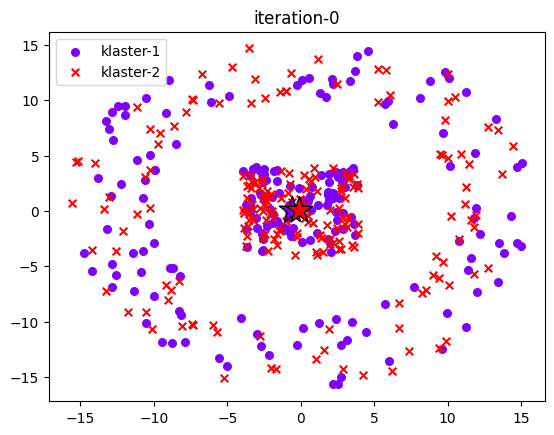

Anggota dari klaster ke- 0 :  196
Anggota dari klaster ke- 1 :  196
iteration- 1 :  6.0  seconds


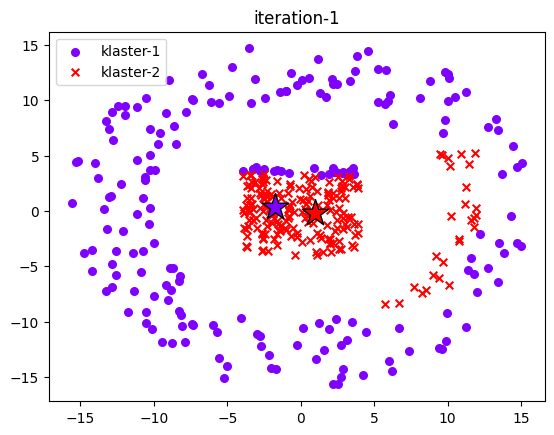

Anggota dari klaster ke- 0 :  200
Anggota dari klaster ke- 1 :  200
iteration- 2 :  5.0  seconds


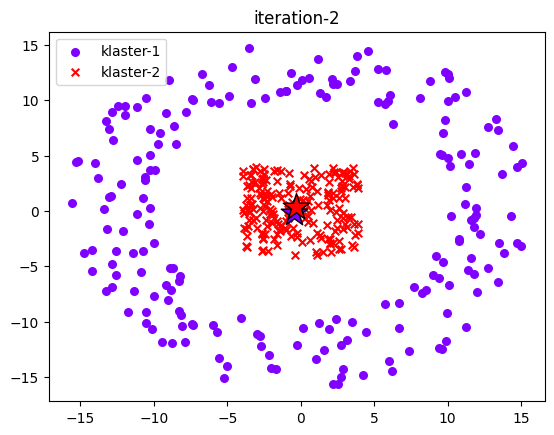

Anggota dari klaster ke- 0 :  200
Anggota dari klaster ke- 1 :  200
Sudah konvergen!


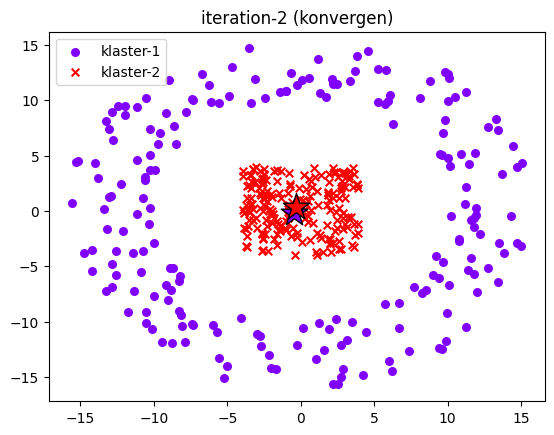

In [11]:
#panggil fungsi kernel k-means yg telah dibuat sebelumnya
clusterResult, centroid = kMeansKernel(input, initMethod)
print("Sudah konvergen!")
#plot hasil akhir dari klasternya
plotResult(clusterResult, centroid, str(iterationCounter) + ' (konvergen)', 1)